In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Data generation
n_samples = 20000
y = np.random.uniform(-0.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Conditional generation
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.5)
    else:
        xtrue[i] = np.random.normal(-1, scale=0.5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, xtrue, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)


class CouplingLayer(nn.Module):
    """An implementation of a coupling layer from RealNVP."""
    def __init__(self, num_inputs, num_hidden, mask, num_cond_inputs=None, s_act='tanh', t_act='relu'):
        super(CouplingLayer, self).__init__()
        self.num_inputs = num_inputs
        self.mask = mask

        activations = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh}
        s_act_func = activations[s_act]
        t_act_func = activations[t_act]

        total_inputs = num_inputs + (num_cond_inputs if num_cond_inputs is not None else 0)
        
        self.scale_net = nn.Sequential(
            nn.Linear(total_inputs, num_hidden), s_act_func(),
            nn.Linear(num_hidden, num_hidden), s_act_func(),
            nn.Linear(num_hidden, num_inputs))
        self.translate_net = nn.Sequential(
            nn.Linear(total_inputs, num_hidden), t_act_func(),
            nn.Linear(num_hidden, num_hidden), t_act_func(),
            nn.Linear(num_hidden, num_inputs))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        mask = self.mask
        
        masked_inputs = inputs * mask
        if cond_inputs is not None:
            masked_inputs = torch.cat([masked_inputs, cond_inputs], -1)
        
        if mode == 'direct':
            log_s = self.scale_net(masked_inputs) * (1 - mask)
            t = self.translate_net(masked_inputs) * (1 - mask)
            s = torch.exp(log_s)
            return inputs * s + t, log_s.sum(-1, keepdim=True)
        else:
            log_s = self.scale_net(masked_inputs) * (1 - mask)
            t = self.translate_net(masked_inputs) * (1 - mask)
            s = torch.exp(-log_s)
            return (inputs - t) * s, -log_s.sum(-1, keepdim=True)


class BatchNormFlow(nn.Module):
    """Batch normalization layer from RealNVP."""
    def __init__(self, num_inputs, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.eps = eps

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            mean = inputs.mean(0)
            var = inputs.var(0, unbiased=False) + self.eps
            x_hat = (inputs - mean) / var.sqrt()
            y = torch.exp(self.log_gamma) * x_hat + self.beta
            return y, (self.log_gamma - 0.5 * torch.log(var)).sum(-1, keepdim=True)
        else:
            mean = inputs.mean(0)
            var = inputs.var(0, unbiased=False) + self.eps
            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)
            y = x_hat * var.sqrt() + mean
            return y, (-self.log_gamma + 0.5 * torch.log(var)).sum(-1, keepdim=True)


class Reverse(nn.Module):
    """Reversing layer."""
    def __init__(self, num_inputs):
        super(Reverse, self).__init__()
        self.perm = np.array(np.arange(0, num_inputs)[::-1])
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(inputs.size(0), 1, device=inputs.device)


class FlowSequential(nn.Sequential):
    """A sequential container for flows."""
    def forward(self, inputs, cond_inputs=None, mode='direct', logdets=None):
        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        for module in (self._modules.values() if mode == 'direct' else reversed(self._modules.values())):
            inputs, logdet = module(inputs, cond_inputs, mode)
            logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, cond_inputs=None):
        u, log_jacob = self(inputs, cond_inputs)
        log_probs = (-0.5 * u.pow(2) - 0.5 * torch.log(2 * torch.pi)).sum(-1, keepdim=True)
        return log_probs + log_jacob

    def sample(self, num_samples, noise=None, cond_inputs=None):
        if noise is None:
            noise = torch.randn(num_samples, self[0].num_inputs)
        return self.forward(noise, cond_inputs, mode='inverse')[0]


# Define MAF model
num_inputs = 1
num_hidden = 64
num_cond_inputs = 1
flows = []

for _ in range(4):  # Number of layers
    mask = torch.randint(0, 2, (num_inputs,))
    flows.append(CouplingLayer(num_inputs, num_hidden, mask, num_cond_inputs))
    flows.append(BatchNormFlow(num_inputs))
    flows.append(Reverse(num_inputs))

model = FlowSequential(*flows)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    u, log_jacob = model(y_train, X_train, mode='direct')
    log_probs = (-0.5 * u.pow(2) - 0.5 * torch.log(torch.tensor(2 * np.pi))).sum(-1, keepdim=True) + log_jacob
    loss = -log_probs.mean()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")



Epoch 0, Loss: 1.4902236461639404
Epoch 10, Loss: 1.439226508140564
Epoch 20, Loss: 1.3693779706954956
Epoch 30, Loss: 1.257836103439331
Epoch 40, Loss: 1.134098768234253
Epoch 50, Loss: 1.0969200134277344
Epoch 60, Loss: 1.0596715211868286
Epoch 70, Loss: 1.035852313041687
Epoch 80, Loss: 1.0107463598251343
Epoch 90, Loss: 0.9880518317222595
Epoch 100, Loss: 0.9678371548652649
Epoch 110, Loss: 0.9478753805160522
Epoch 120, Loss: 0.9315345287322998
Epoch 130, Loss: 0.9141605496406555
Epoch 140, Loss: 0.8989205360412598
Epoch 150, Loss: 0.904019832611084
Epoch 160, Loss: 0.8908230662345886
Epoch 170, Loss: 0.9092397689819336
Epoch 180, Loss: 0.8764445185661316
Epoch 190, Loss: 0.9010437726974487
Epoch 200, Loss: 0.8786073923110962
Epoch 210, Loss: 0.8725329637527466
Epoch 220, Loss: 0.8708183169364929
Epoch 230, Loss: 0.8709926009178162
Epoch 240, Loss: 0.8660861849784851
Epoch 250, Loss: 0.8557507991790771
Epoch 260, Loss: 0.8918627500534058
Epoch 270, Loss: 0.8609346151351929
Epoch 28

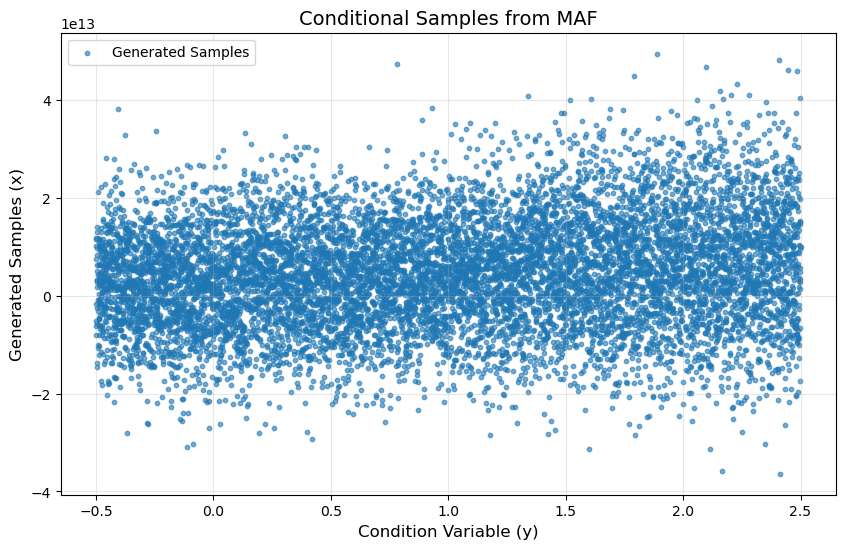

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `model` is already defined and trained
# Generate samples conditioned on `y` values
num_samples = 10000
y_cond = torch.linspace(-0.5, 2.5, num_samples).unsqueeze(-1)  # Range of y values to condition on
samples = model.sample(num_samples=num_samples, cond_inputs=y_cond).detach().numpy()

# Convert `y_cond` to numpy for plotting
y_cond_numpy = y_cond.numpy()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_cond_numpy, samples, alpha=0.6, s=10, label='Generated Samples')
plt.title('Conditional Samples from MAF', fontsize=14)
plt.xlabel('Condition Variable (y)', fontsize=12)
plt.ylabel('Generated Samples (x)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
